## Importing Libraries

In [106]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Extract, Transform, and Load 

In [107]:
conn = sqlite3.connect("Final.db")
cursor = conn.cursor()
cursor.execute("SELECT * FROM raw_stroke_data")
cursor.fetchall()

[('id',
  'gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status',
  'stroke'),
 ('9046',
  'Male',
  '67',
  '0',
  '1',
  'Yes',
  'Private',
  'Urban',
  '228.69',
  '36.6',
  'formerly smoked',
  '1'),
 ('51676',
  'Female',
  '61',
  '0',
  '0',
  'Yes',
  'Self-employed',
  'Rural',
  '202.21',
  'N/A',
  'never smoked',
  '1'),
 ('31112',
  'Male',
  '80',
  '0',
  '1',
  'Yes',
  'Private',
  'Rural',
  '105.92',
  '32.5',
  'never smoked',
  '1'),
 ('60182',
  'Female',
  '49',
  '0',
  '0',
  'Yes',
  'Private',
  'Urban',
  '171.23',
  '34.4',
  'smokes',
  '1'),
 ('1665',
  'Female',
  '79',
  '1',
  '0',
  'Yes',
  'Self-employed',
  'Rural',
  '174.12',
  '24',
  'never smoked',
  '1'),
 ('56669',
  'Male',
  '81',
  '0',
  '0',
  'Yes',
  'Private',
  'Urban',
  '186.21',
  '29',
  'formerly smoked',
  '1'),
 ('53882',
  'Male',
  '74',
  '1',
  '1',
  'Yes',
  'Privat

In [108]:
# Read data in a data frame
df = pd.read_sql_query("SELECT * FROM raw_stroke_data", conn)
df.head()

,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12
0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [109]:
# Drop ID column
df1 = df.drop(['field1'], axis=1)
df1.head()

,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12
0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
3,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [110]:
# Drop first row with numerated fields
df1.columns = df1.iloc[0]
df2 = df1.drop(df.index[[0]])
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
3,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [111]:
df2.shape

(5110, 11)

In [112]:
# Check variables data type 
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 1 to 5110
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             5110 non-null   object
 1   age                5110 non-null   object
 2   hypertension       5110 non-null   object
 3   heart_disease      5110 non-null   object
 4   ever_married       5110 non-null   object
 5   work_type          5110 non-null   object
 6   Residence_type     5110 non-null   object
 7   avg_glucose_level  5110 non-null   object
 8   bmi                5110 non-null   object
 9   smoking_status     5110 non-null   object
 10  stroke             5110 non-null   object
dtypes: object(11)
memory usage: 479.1+ KB


In [113]:
# Convert 'Object' data type to integer and float
df2['age'] = df2['age'].astype(float)
df2['hypertension'] = df2['hypertension'].astype(int)
df2['heart_disease'] = df2['heart_disease'].astype(int)
df2['avg_glucose_level'] = df2['avg_glucose_level'].astype(float)
df2['stroke'] = df2['stroke'].astype(int)

In [114]:
# Replace 'N/A' from 'bmi' column with zero to be able to convert 'Object' data type to float
df2['bmi'] = df2['bmi'].replace({'N/A':0}).astype(float)

df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
3,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [115]:
# Convert 0 values to NaN to replace them later with the median
df2['bmi'] = df2['bmi'].replace({0:'NaN'}).astype(float)

df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
3,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [116]:
# Replace 'NaN' values with the median
df2["bmi"].fillna(df2["bmi"].median(), inplace=True)
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
3,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [117]:
# Check unique values
df2['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [118]:
# Count how many 'Other' values are in gender column
df2['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [119]:
# Drop the row that contains 'Other' value
other_value = df2[df2['gender'] =='Other'].index
df3 = df2.drop(other_value)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 1 to 5110
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int32  
 3   heart_disease      5109 non-null   int32  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int32  
dtypes: float64(3), int32(3), object(5)
memory usage: 419.1+ KB


Since we dropped 1 row, now we have 5109 rows.

In [120]:
# Check if there are any null values
df3.isnull().sum()

0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Data Visualization

0    4860
1     249
Name: stroke, dtype: int64

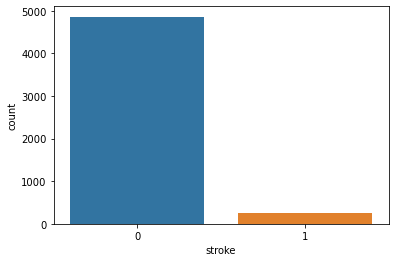

In [121]:
# Visualize distribution of predicted values  
sns.countplot(x='stroke', data=df3)
df3.stroke.value_counts()

From the graph above we can clearly see that the data is not normally distributed. There are more negative variables (no stroke detected) than positives.

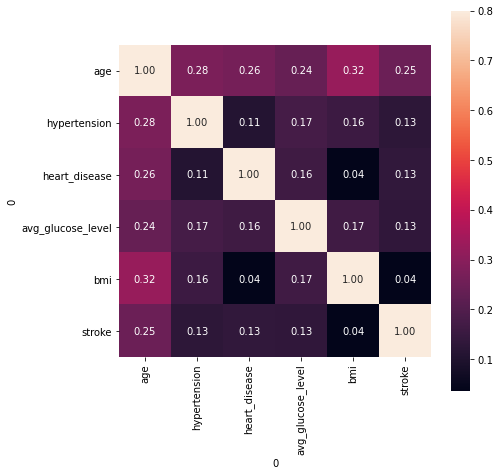

In [122]:
# Check what correlation can be found between the stroke and variables in the dataset
correlation = df3.corr()
fig, axes = plt.subplots(figsize=(7, 7))
sns.heatmap(correlation, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

There is a week correlation between stroke and age (25%). Also, we can notice a very week correlation of 13% between stroke and hypertension, heart disease, and glucose level. We do have such a week correlation because the data in not normally distributed.

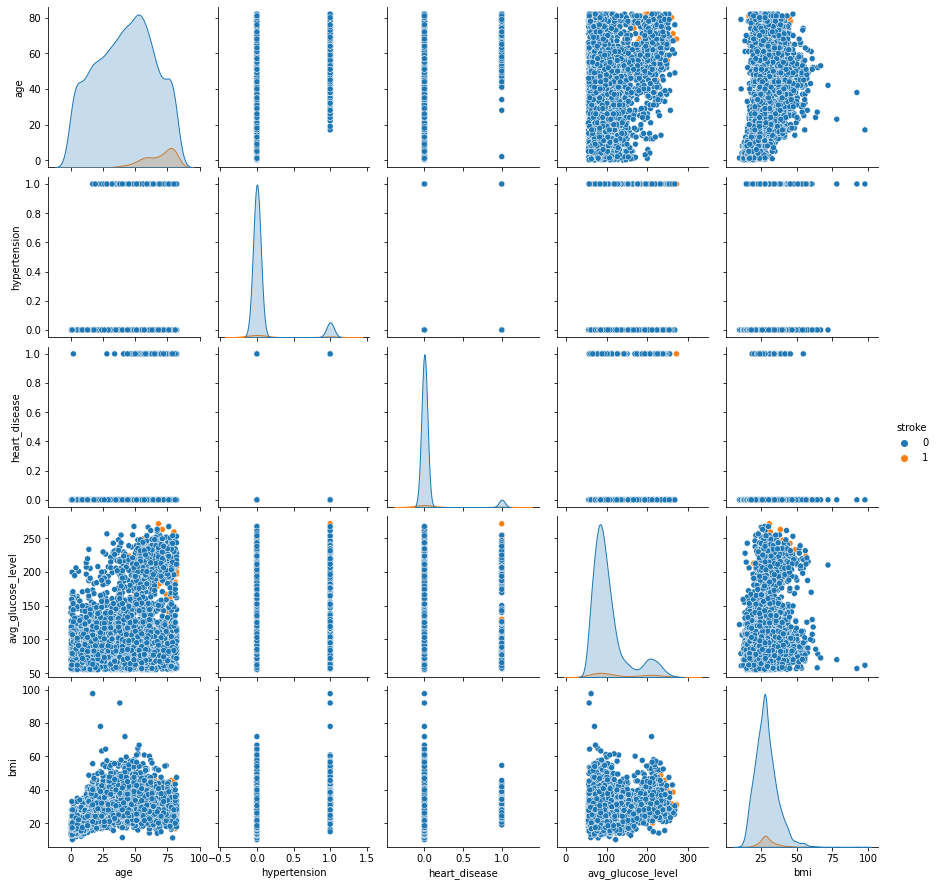

In [123]:
sns.pairplot(df3,hue='stroke')

## Label encoding

In [124]:
encoded_data = pd.get_dummies(df3, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',], drop_first=True)
encoded_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
2,61.0,0,0,202.21,28.1,1,0,1,0,0,1,0,0,0,1,0
3,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
4,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
5,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106,80.0,1,0,83.75,28.1,0,0,1,0,1,0,0,1,0,1,0
5107,81.0,0,0,125.20,40.0,0,0,1,0,0,1,0,1,0,1,0
5108,35.0,0,0,82.99,30.6,0,0,1,0,0,1,0,0,0,1,0
5109,51.0,0,0,166.29,25.6,0,1,1,0,1,0,0,0,1,0,0


In [125]:
# Defining features and target sets

X = encoded_data.drop('stroke', axis=1)
y = encoded_data.pop('stroke')

In [126]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4087, 15), (4087,), (1022, 15), (1022,))

## Scaling the data

In [127]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 1.58859399, -0.3201699 , -0.23038903, ...,  2.18276361,
        -0.76226274, -0.42969487],
       [ 0.83688063, -0.3201699 , -0.23038903, ..., -0.45813481,
        -0.76226274, -0.42969487],
       [-0.97607511, -0.3201699 , -0.23038903, ..., -0.45813481,
         1.31188361, -0.42969487],
       ...,
       [-1.85336881, -0.3201699 , -0.23038903, ..., -0.45813481,
        -0.76226274, -0.42969487],
       [-0.22436175, -0.3201699 , -0.23038903, ..., -0.45813481,
         1.31188361, -0.42969487],
       [ 0.12938571, -0.3201699 , -0.23038903, ..., -0.45813481,
        -0.76226274,  2.32723281]])

In [128]:
# Check the numbers of positive and negative predicted stroke in training set

from collections import Counter
Counter(y_train)

Counter({0: 3900, 1: 187})

In this dataset, we encounter imbalanced data with only 4.7% of the data being positive for stroke. We will use SMOTE method to normalize the data.  Why is this important? The model learns over time coursing through the data. Based on the provided data it finds patterns and distinguishes between them to make predictions.
The model looks at the data and find patterns distinguishing between them to make predictions. A model's effectiveness is deduced from the accuracy of the predictions. Since our data has only 4.7 %  positive predictions, the model can learn to predict negative values in all cases. Thus, while the model has a 95% accuracy, it cannot catch a patient having a stroke. 
In order to avoid this situation, we have to be able to distinguish between the false negative (when the model should predict stroke but does not) and true negative values. It is okay if the model has a few false positive values (determining stroke when the patient doesn't have one) but false negative values should be avoided completely.

In [129]:
# Oversample X and y training sets
X_resampled, y_resampled = SMOTE(random_state=1).fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0: 3900, 1: 3900})

## 1. Support Vector Machine

In [130]:
# Create SVM model
SVM_model = SVC(kernel='linear')

# Fit the model using resampled data
SVM_model.fit(X_resampled, y_resampled)

# Create predictions
y_pred = SVM_model.predict(X_test)

# Calculated the balanced accuracy score
acc_score = balanced_accuracy_score(y_test, y_pred)
acc_score

0.7613071236559139

### Balanced Accuracy vs Accuracy
**Accuracy** = (TP + TN) / (TP+FN+FP+TN)

**Balanced Accuracy** = (Sensitivity + Specificity) / 2
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)

**Accuracy score** looks impressive, but it isn’t handling the Positive column properly.

**Balanced Accuracy** does a great job because we want to identify the positives present in our classifier. This makes the score lower than what accuracy predicts as it gives the same weight to both classes.

- *In my analysis will use both scores.*

### Evaluate the model

In [131]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,703,257
Actual 1,13,49


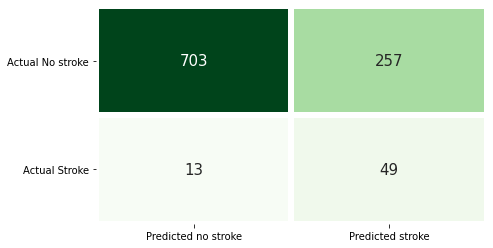

In [132]:
# Display the confusion matrix
plt.figure(figsize = (7, 4))
sns.heatmap(cm, cmap = 'Greens', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Actual No stroke', 'Actual Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

In [133]:
print(classification_report(y_test, y_pred))
score = cross_val_score(SVM_model, X_train, y_train, cv = 6)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy Score:',accuracy_score(y_test,y_pred))
print ('--')
print('F1 Score:',f1_score(y_test,y_pred))
print ('--')
print ('Train score:', score.mean())
print ('--')
print ('Precision score:', precision)
print ('--')
print ('Recall Score:', recall)

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       960
           1       0.16      0.79      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.74      0.80      1022

Accuracy Score: 0.735812133072407
--
F1 Score: 0.2663043478260869
--
Train score: 0.9542454529664988
--
Precision score: 0.16013071895424835
--
Recall Score: 0.7903225806451613


## 2. KNeighbors

In [134]:
# Create KNeighbors model
KNN_model = KNeighborsClassifier()

# Fit the model
KNN_model.fit(X_resampled, y_resampled)

# Create predictions
y_pred = KNN_model.predict(X_test)

# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.6052755376344086

In [135]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,806,154
Actual 1,39,23


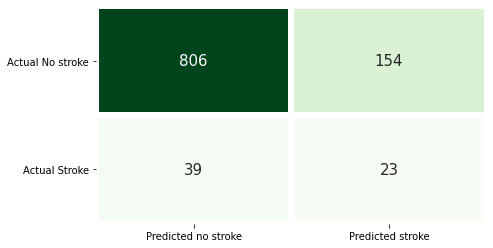

In [136]:
# Display the confusion matrix
plt.figure(figsize = (7, 4))
sns.heatmap(cm, cmap = 'Greens', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Actual No stroke', 'Actual Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

In [137]:
print(classification_report(y_test, y_pred))
score = cross_val_score(KNN_model, X_train, y_train, cv = 6)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy Score:',accuracy_score(y_test,y_pred))
print ('--')
print('F1 Score:',f1_score(y_test,y_pred))
print ('--')
print ('Train score:', score.mean())
print ('--')
print ('Precision score:', precision)
print ('--')
print ('Recall Score:', recall)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       960
           1       0.13      0.37      0.19        62

    accuracy                           0.81      1022
   macro avg       0.54      0.61      0.54      1022
weighted avg       0.90      0.81      0.85      1022

Accuracy Score: 0.8111545988258317
--
F1 Score: 0.19246861924686193
--
Train score: 0.9527770241852949
--
Precision score: 0.12994350282485875
--
Recall Score: 0.3709677419354839


## 3. RandomForestClassifier

In [138]:
# Create Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fit the model
rf_model.fit(X_resampled, y_resampled)

# Create predictions
y_pred = rf_model.predict(X_test)

# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5447244623655914

In [139]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,922,38
Actual 1,54,8


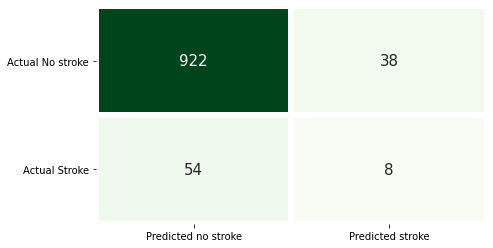

In [140]:
# Display the confusion matrix
plt.figure(figsize = (7, 4))
sns.heatmap(cm, cmap = 'Greens', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Actual No stroke', 'Actual Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

In [141]:
print(classification_report(y_test, y_pred))
score = cross_val_score(rf_model, X_train, y_train, cv = 6)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy Score:',accuracy_score(y_test,y_pred))
print ('--')
print('F1 Score:',f1_score(y_test,y_pred))
print ('--')
print ('Train score:', score.mean())
print ('--')
print ('Precision score:', precision)
print ('--')
print ('Recall Score:', recall)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       960
           1       0.17      0.13      0.15        62

    accuracy                           0.91      1022
   macro avg       0.56      0.54      0.55      1022
weighted avg       0.90      0.91      0.90      1022

Accuracy Score: 0.9099804305283757
--
F1 Score: 0.14814814814814814
--
Train score: 0.9540007148362982
--
Precision score: 0.17391304347826086
--
Recall Score: 0.12903225806451613


## 4. Logistic Regression

In [142]:
# Create Logistic Regression model
LR_model = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model
LR_model.fit(X_resampled, y_resampled)

# Create predictions
y_pred = LR_model.predict(X_test)

# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.7623487903225806

In [143]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,705,255
Actual 1,13,49


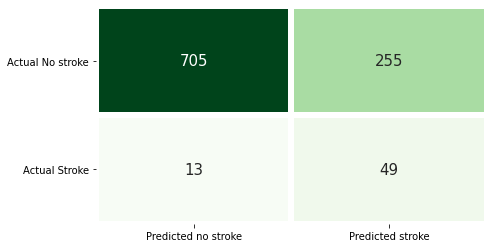

In [144]:
# Display the confusion matrix
plt.figure(figsize = (7, 4))
sns.heatmap(cm, cmap = 'Greens', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Actual No stroke', 'Actual Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

In [145]:
print(classification_report(y_test, y_pred))
score = cross_val_score(LR_model, X_train, y_train, cv = 6)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy Score:',accuracy_score(y_test,y_pred))
print ('--')
print('F1 Score:',f1_score(y_test,y_pred))
print ('--')
print ('Train score:', score.mean())
print ('--')
print ('Precision score:', precision)
print ('--')
print ('Recall Score:', recall)

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       960
           1       0.16      0.79      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.74      0.81      1022

Accuracy Score: 0.7377690802348337
--
F1 Score: 0.2677595628415301
--
Train score: 0.9544898322431362
--
Precision score: 0.1611842105263158
--
Recall Score: 0.7903225806451613


## 5. Decision Tree Classifier

In [146]:
# Create DecisionTreeClassifier model
DT_model = DecisionTreeClassifier()

# Fit the model
DT_model.fit(X_resampled, y_resampled)

# Create predictions
y_pred = DT_model.predict(X_test)

# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5772177419354838

In [147]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,876,84
Actual 1,47,15


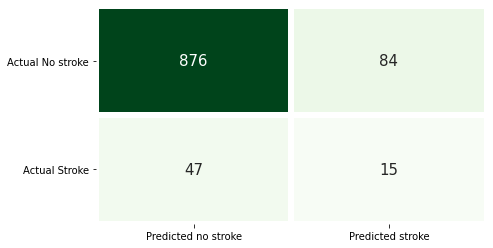

In [148]:
# Display the confusion matrix
plt.figure(figsize = (7, 4))
sns.heatmap(cm, cmap = 'Greens', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Actual No stroke', 'Actual Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

In [149]:
print(classification_report(y_test, y_pred))
score = cross_val_score(DT_model, X_train, y_train, cv = 6)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy Score:',accuracy_score(y_test,y_pred))
print ('--')
print('F1 Score:',f1_score(y_test,y_pred))
print ('--')
print ('Train score:', score.mean())
print ('--')
print ('Precision score:', precision)
print ('--')
print ('Recall Score:', recall)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       960
           1       0.15      0.24      0.19        62

    accuracy                           0.87      1022
   macro avg       0.55      0.58      0.56      1022
weighted avg       0.90      0.87      0.89      1022

Accuracy Score: 0.8718199608610567
--
F1 Score: 0.1863354037267081
--
Train score: 0.9121605424717546
--
Precision score: 0.15151515151515152
--
Recall Score: 0.24193548387096775
